# Analysis of domain with recall time

In [2]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences, designed_matrix_sequences_local
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence, create_sequence_chain
from analysis import time_t1, time_t2, time_t1_local, time_t2_local, time_t2_complicated
from network import run_network_recall_limit_end


## Load and produce the data

In [3]:
from sklearn.model_selection import train_test_split
import sklearn.linear_model as linear_model


N = 10
tau_z_post = 0.005
tau_w = 0.100


training_time = 0.100
inter_sequence_time = 1.000
dt = 0.001
epochs = 4
sequence1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sequences = [sequence1]

threshold  = 0.5
G = 500.0
tau_m = 0.010
I_cue = 0
I_end = 5
T = 10.0
pre_rule = False


pattern = 3
pattern_from = 2

saved_matrix = True
n_samples = 1000
outfile = '../data_training_n_samples' + str(n_samples) + 'pre_rule_' + str(pre_rule)
extension = '.npz'
outfile += extension
outfile = '../data_training_n_samples5000pre_rule_False.npz'
if not saved_matrix:

    max_w_vector = np.random.uniform(low=1, high=200, size=n_samples)
    min_w_vector = -np.random.uniform(low=1, high=100, size=n_samples)
    tau_z_vector = np.random.uniform(low=0.050, high=1.050, size=n_samples)
    training_vector = np.random.uniform(low=0.100, high=1.000, size=n_samples)

    X = np.zeros((n_samples, 4))
    y = np.zeros((n_samples, 4))

    for index, (tau_z, max_w, min_w, training_time) in enumerate(zip(tau_z_vector, max_w_vector,
                                                                     min_w_vector, training_vector)):

        print(index)

        T_cue = tau_z
        dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z, tau_z_post,
                        tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=True, pre_rule=pre_rule)

        w = dic['w']
        # Extract ther recall time
        dic = run_network_recall_limit_end(N, w, G, threshold, tau_m, tau_z, T, dt, I_cue, I_end, T_cue, sigma=0)
        x_history = dic['x']

        duration = get_recall_duration_for_pattern(x_history, pattern, dt)


        self = w[pattern, pattern]
        exc = w[pattern, pattern_from]
        inh = w[pattern_from, pattern]


        y[index, 0] = self
        y[index, 1] = exc
        y[index, 2] = inh
        y[index, 3] = duration

        X[index, 0] = tau_z
        X[index, 1] = max_w
        X[index, 2] = min_w
        X[index, 3] = training_time

    # Now we save both X and Y
    np.savez(outfile, x=X, y=y)
else:
    npz_file = np.load(outfile)
    X = npz_file['x']
    y = npz_file['y']

In [4]:
# Here we do the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y[:, [0, 1, 2]], test_size=0.1, random_state=0)

reg = linear_model.LinearRegression(fit_intercept=False, n_jobs=-1)
reg.fit(X_train, y_train)
score = reg.score(X_test, y_test)
A = reg.coef_
# B = np.linalg.inv(A)
print('score', score)

score 0.837236013956


## Analysis

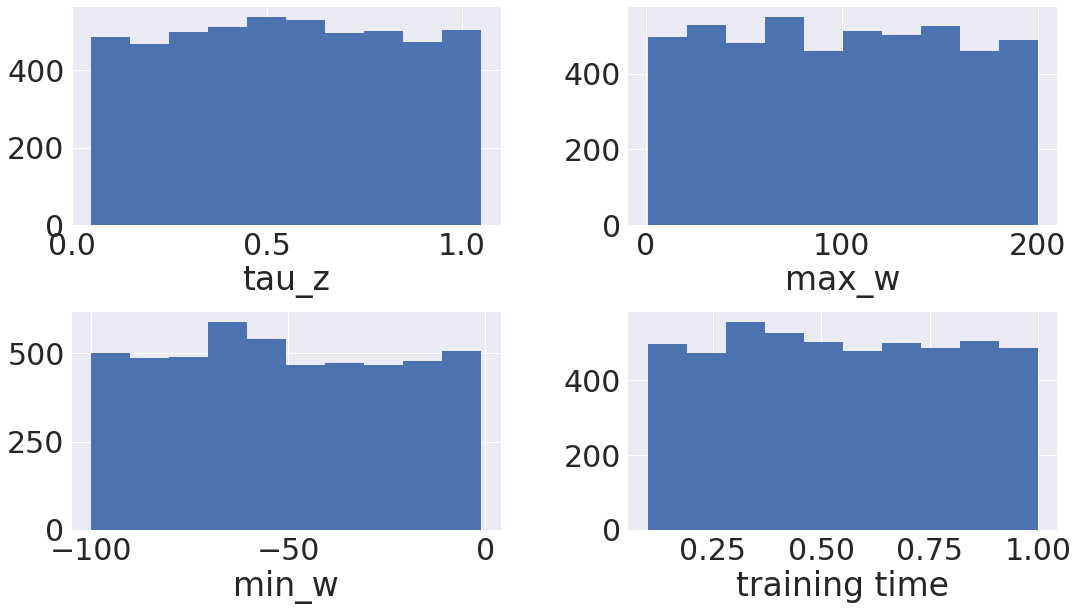

In [5]:
x = X
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

ax1.hist(x[:, 0])
ax1.set_xlabel('tau_z')

ax2.hist(x[:, 1])
ax2.set_xlabel('max_w')

ax3.hist(x[:, 2])
ax3.set_xlabel('min_w')

ax4.hist(x[:, 3])
ax4.set_xlabel('training time');

We see that we sample equally.

Let's see how it looks like after we prun for the values that actually are useful for producing sequential behavior

In [6]:
n_samples = X.shape[0]
number_of_nan = np.isnan(y[:, 3]).sum()

number_working = n_samples - number_of_nan
print('working data', number_working)
working_recall_indexes = ~np.isnan(y[:, 3])

working data 3582


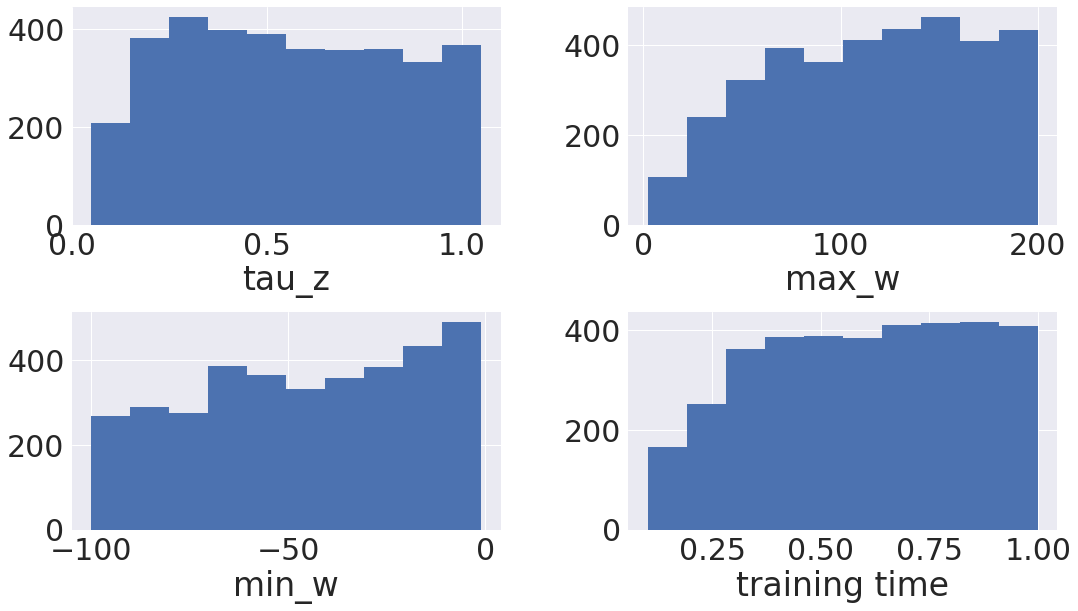

In [7]:
x = X[working_recall_indexes, :]

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

ax1.hist(x[:, 0])
ax1.set_xlabel('tau_z')

ax2.hist(x[:, 1])
ax2.set_xlabel('max_w')

ax3.hist(x[:, 2])
ax3.set_xlabel('min_w')

ax4.hist(x[:, 3])
ax4.set_xlabel('training time');

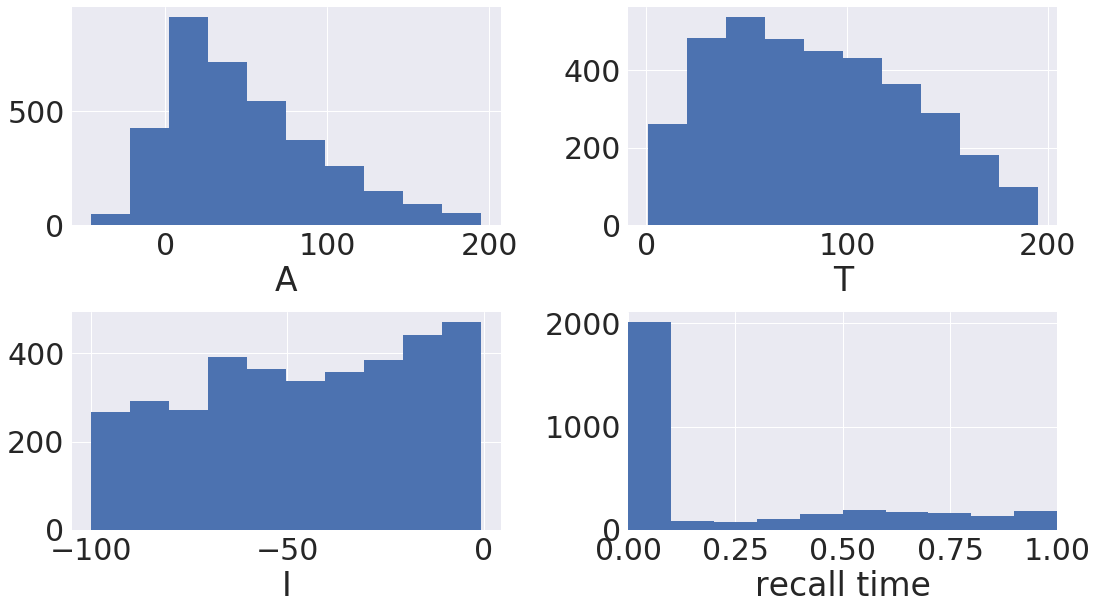

In [8]:
Y = y[working_recall_indexes, :]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

ax1.hist(Y[:, 0])
ax1.set_xlabel('A')

ax2.hist(Y[:, 1])
ax2.set_xlabel('T')

ax3.hist(Y[:, 2])
ax3.set_xlabel('I')

ax4.hist(Y[:, 3], bins=100)
ax4.set_xlim([0, 1.0])
ax4.set_xlabel('recall time');

In [9]:
y.shape

(5000, 4)

Now let's go for the right domain

In [10]:
# I want to calculate the values for which the self-excitation and the transition are positive
positive_A = y[:, 0] > 0
positive_T = y[:, 1] > 0
negative_I = y[:, 2] < 0

# Now the values that generated the valures in the correct domain are
domain_indexes = positive_A * positive_T * negative_I

And let's see how many of the actual domain indexes coincide with the indexes that make the recall time work

In [11]:
print('right domain size', domain_indexes.sum())
print('correctly recall', working_recall_indexes.sum())

domain_and_correct = domain_indexes * working_recall_indexes
domain_and_correct.sum()

right domain size 3411
correctly recall 3582


3189

That means that most of the domain size is correctly recall. But there are some numbers that are correctly recall that DO NOT BELONG TO THE DOMAIN

Let's see what is happening here

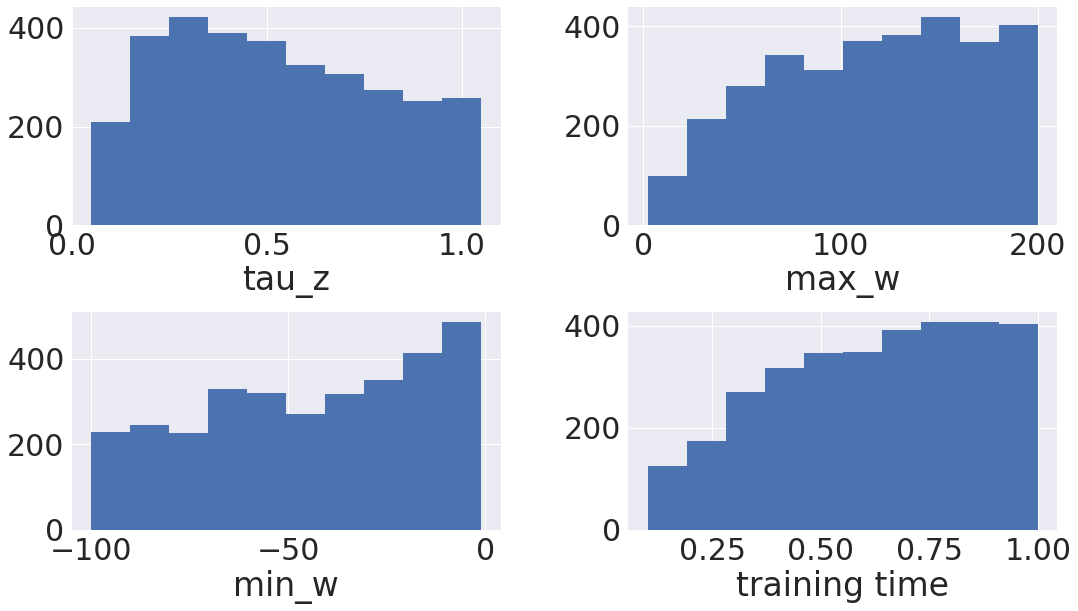

In [12]:
x = X[domain_and_correct, :]

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

ax1.hist(x[:, 0])
ax1.set_xlabel('tau_z')

ax2.hist(x[:, 1])
ax2.set_xlabel('max_w')

ax3.hist(x[:, 2])
ax3.set_xlabel('min_w')

ax4.hist(x[:, 3])
ax4.set_xlabel('training time');

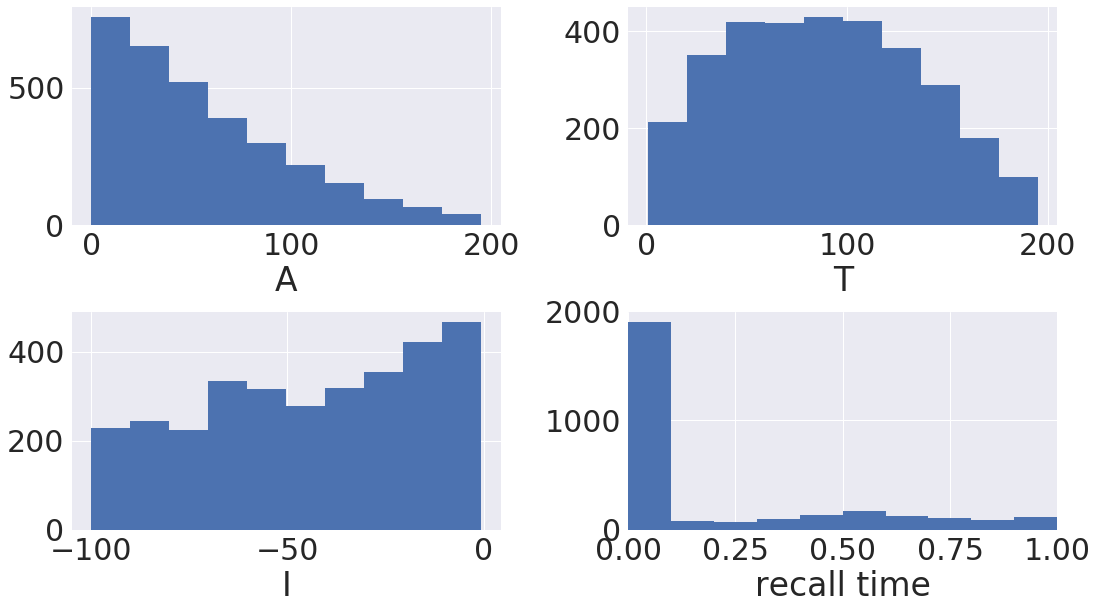

In [13]:
Y = y[domain_and_correct, :]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

ax1.hist(Y[:, 0])
ax1.set_xlabel('A')

ax2.hist(Y[:, 1])
ax2.set_xlabel('T')

ax3.hist(Y[:, 2])
ax3.set_xlabel('I')

ax4.hist(Y[:, 3], bins=100)
ax4.set_xlim([0, 1.0])
ax4.set_xlabel('recall time');

Well, not surprinsgly we got rid of the A and T that were negative but the interesting thing is how the recall times were affected. There is thinning of it at the beggining of the distribution but also some longer recall times were supprssed.

Let's look at this from the point of view of disperssion

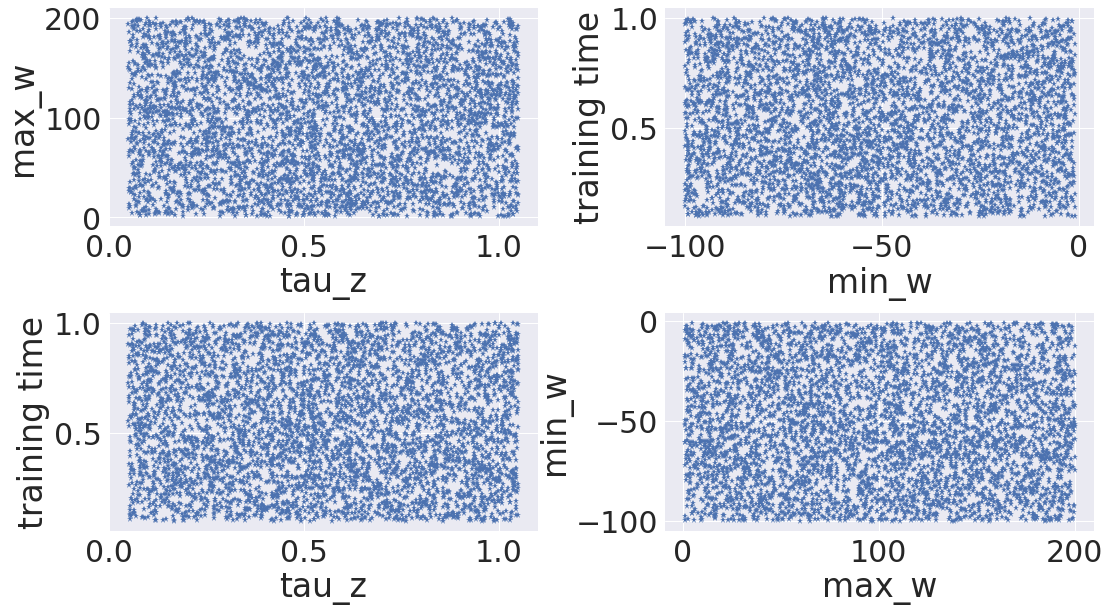

In [14]:
x = X

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

ax1.plot(x[:, 0], x[:, 1], '*')
ax1.set_xlabel('tau_z')
ax1.set_ylabel('max_w')

ax2.plot(x[:, 2], x[:, 3], '*')
ax2.set_xlabel('min_w')
ax2.set_ylabel('training time')

ax3.plot(x[:, 0], x[:, 3], '*')
ax3.set_xlabel('tau_z')
ax3.set_ylabel('training time')


ax4.plot(x[:, 1], x[:, 2], '*')
ax4.set_xlabel('max_w')
ax4.set_ylabel('min_w');


Now if we take the ones that actually producing working sequences

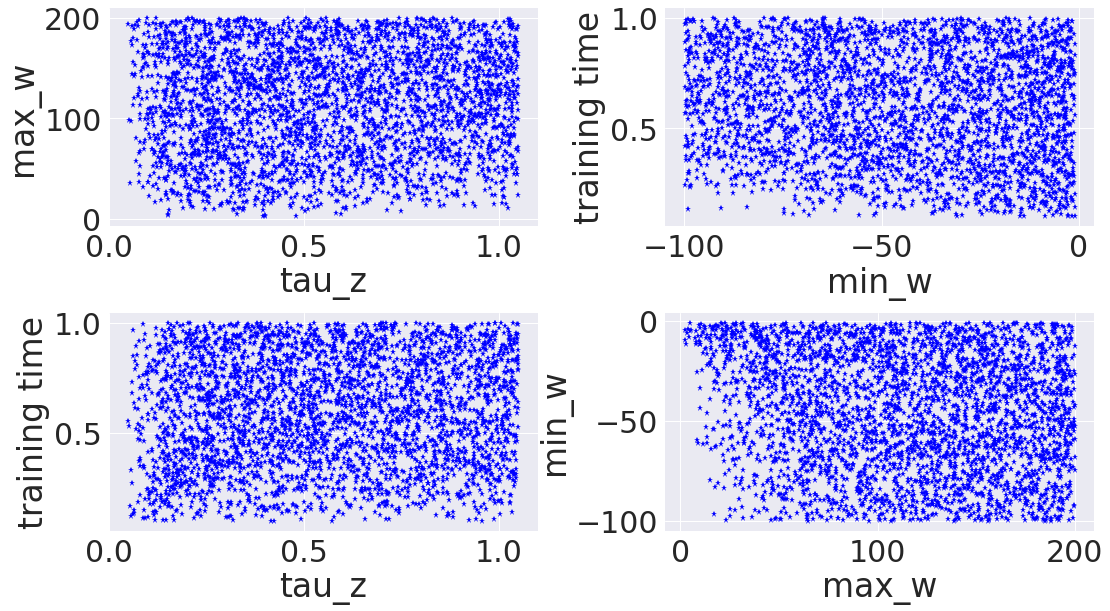

In [15]:
x = X[working_recall_indexes, :]

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(x[:, 0], x[:, 1], '*', color=color)
ax1.set_xlabel('tau_z')
ax1.set_ylabel('max_w')

ax2.plot(x[:, 2], x[:, 3], '*', color=color)
ax2.set_xlabel('min_w')
ax2.set_ylabel('training time')

ax3.plot(x[:, 0], x[:, 3], '*', color=color)
ax3.set_xlabel('tau_z')
ax3.set_ylabel('training time')


ax4.plot(x[:, 1], x[:, 2], '*', color=color)
ax4.set_xlabel('max_w')
ax4.set_ylabel('min_w');


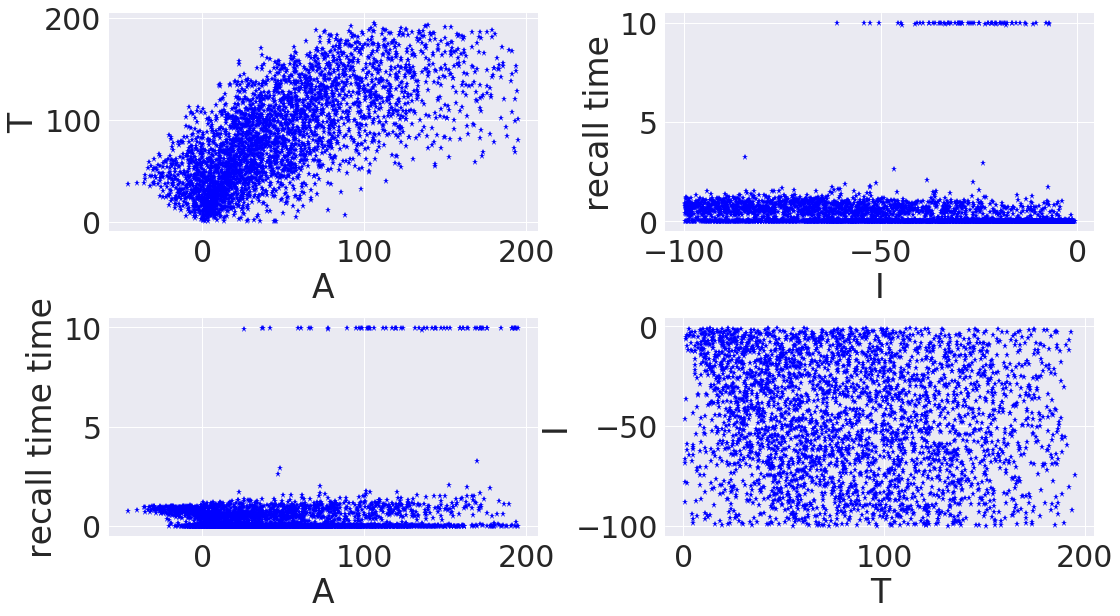

In [16]:
Y = y[working_recall_indexes, :]

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(Y[:, 0], Y[:, 1], '*', color=color)
ax1.set_xlabel('A')
ax1.set_ylabel('T')

ax2.plot(Y[:, 2], Y[:, 3], '*', color=color)
ax2.set_xlabel('I')
ax2.set_ylabel('recall time')

ax3.plot(Y[:, 0], Y[:, 3], '*', color=color)
ax3.set_xlabel('A')
ax3.set_ylabel('recall time time')


ax4.plot(Y[:, 1], Y[:, 2], '*', color=color)
ax4.set_xlabel('T')
ax4.set_ylabel('I');


Let's check both correct recall and right domain

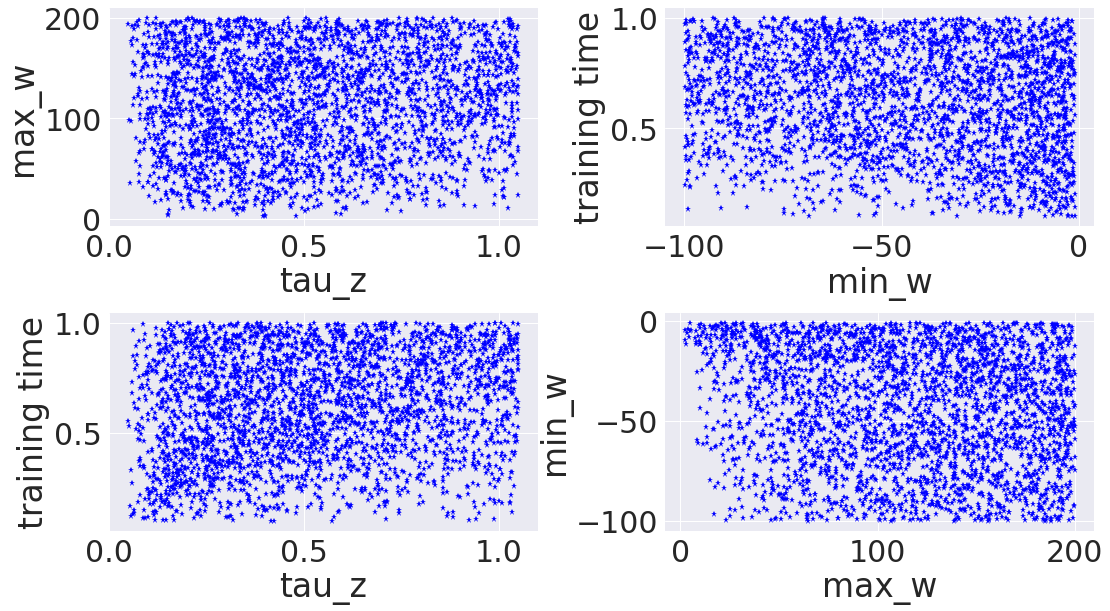

In [17]:
x = X[domain_and_correct, :]

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(x[:, 0], x[:, 1], '*', color=color)
ax1.set_xlabel('tau_z')
ax1.set_ylabel('max_w')

ax2.plot(x[:, 2], x[:, 3], '*', color=color)
ax2.set_xlabel('min_w')
ax2.set_ylabel('training time')

ax3.plot(x[:, 0], x[:, 3], '*', color=color)
ax3.set_xlabel('tau_z')
ax3.set_ylabel('training time')


ax4.plot(x[:, 1], x[:, 2], '*', color=color)
ax4.set_xlabel('max_w')
ax4.set_ylabel('min_w');


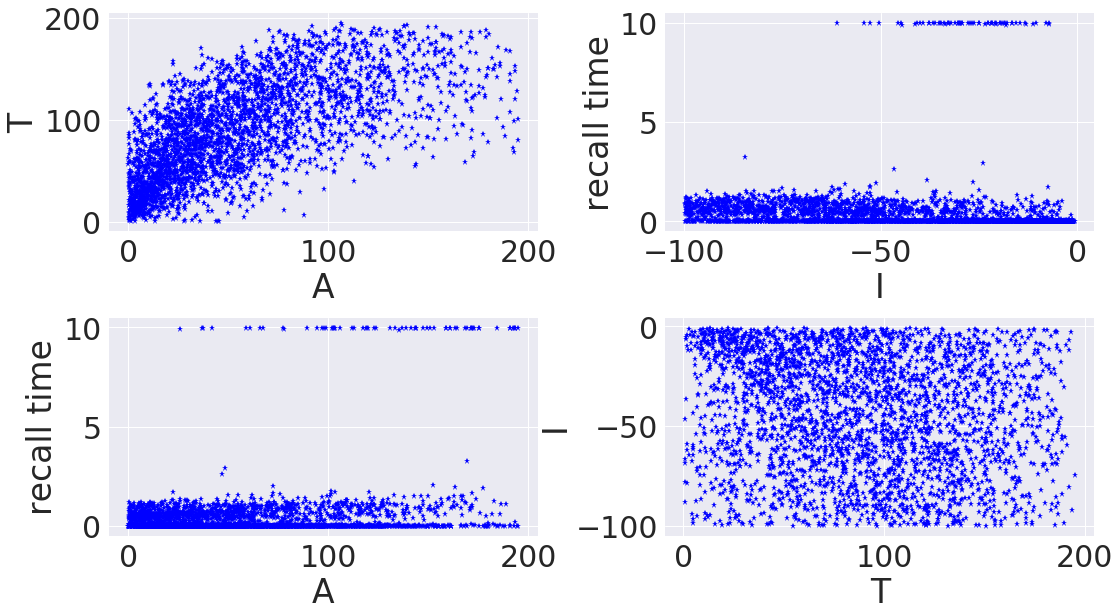

In [18]:
Y = y[domain_and_correct, :]

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(Y[:, 0], Y[:, 1], '*', color=color)
ax1.set_xlabel('A')
ax1.set_ylabel('T')

ax2.plot(Y[:, 2], Y[:, 3], '*', color=color)
ax2.set_xlabel('I')
ax2.set_ylabel('recall time')

ax3.plot(Y[:, 0], Y[:, 3], '*', color=color)
ax3.set_xlabel('A')
ax3.set_ylabel('recall time')


ax4.plot(Y[:, 1], Y[:, 2], '*', color=color)
ax4.set_xlabel('T')
ax4.set_ylabel('I');


In order to have a better appreciation of the recall time dynamics let's eliminate the indexes where recall time is bigger than one second

In [19]:
small_recall_indexes = y[:, 3] < 1.0
small_domain_and_correct = small_recall_indexes * domain_and_correct

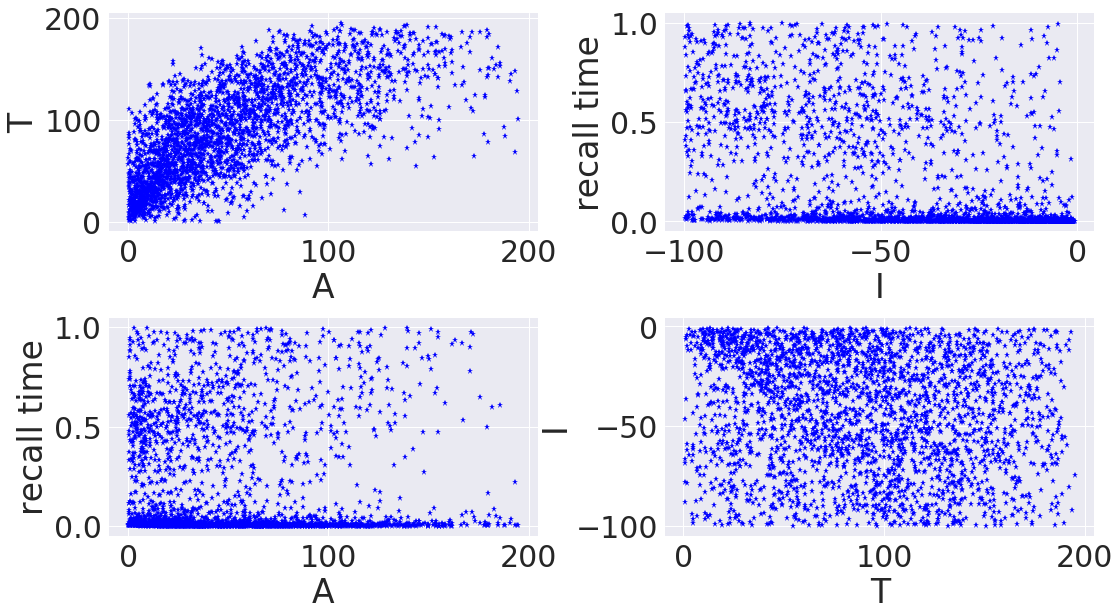

In [20]:
Y = y[small_domain_and_correct, :]

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(Y[:, 0], Y[:, 1], '*', color=color)
ax1.set_xlabel('A')
ax1.set_ylabel('T')

ax2.plot(Y[:, 2], Y[:, 3], '*', color=color)
ax2.set_xlabel('I')
ax2.set_ylabel('recall time')

ax3.plot(Y[:, 0], Y[:, 3], '*', color=color)
ax3.set_xlabel('A')
ax3.set_ylabel('recall time')


ax4.plot(Y[:, 1], Y[:, 2], '*', color=color)
ax4.set_xlabel('T')
ax4.set_ylabel('I');


I am interested in picking numbers of tau_z, training time, max_w and min_w that make me correctly recall in order to do that let's see what sub-sections of the scatter diagram are actually useful when I restrict myself to that

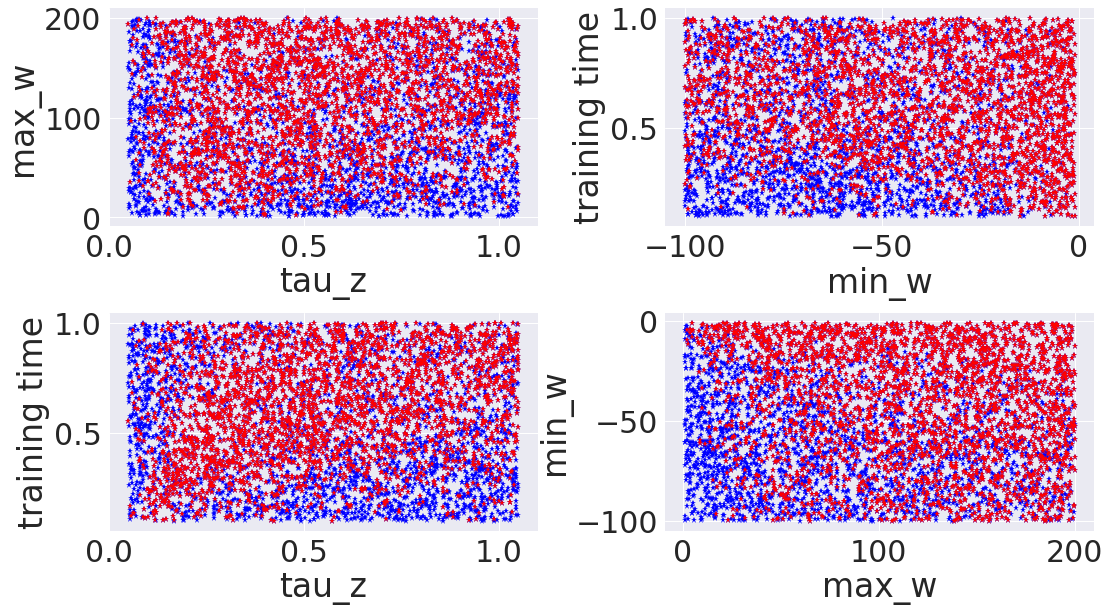

In [21]:
x = X

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(x[:, 0], x[:, 1], '*', color=color)
ax1.set_xlabel('tau_z')
ax1.set_ylabel('max_w')

ax2.plot(x[:, 2], x[:, 3], '*', color=color)
ax2.set_xlabel('min_w')
ax2.set_ylabel('training time')

ax3.plot(x[:, 0], x[:, 3], '*', color=color)
ax3.set_xlabel('tau_z')
ax3.set_ylabel('training time')


ax4.plot(x[:, 1], x[:, 2], '*', color=color)
ax4.set_xlabel('max_w')
ax4.set_ylabel('min_w');


x = X[small_domain_and_correct]
color = 'red'

ax1.plot(x[:, 0], x[:, 1], '*', color=color)
ax1.set_xlabel('tau_z')
ax1.set_ylabel('max_w')

ax2.plot(x[:, 2], x[:, 3], '*', color=color)
ax2.set_xlabel('min_w')
ax2.set_ylabel('training time')

ax3.plot(x[:, 0], x[:, 3], '*', color=color)
ax3.set_xlabel('tau_z')
ax3.set_ylabel('training time')


ax4.plot(x[:, 1], x[:, 2], '*', color=color)
ax4.set_xlabel('max_w')
ax4.set_ylabel('min_w');


## Recall time dependency

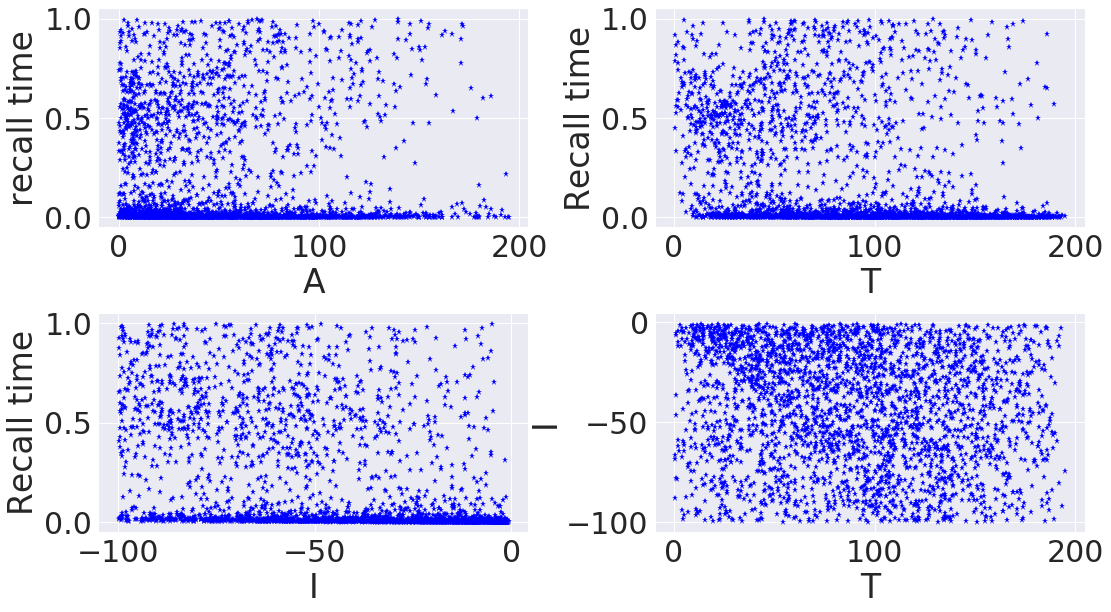

In [22]:
Y = y[small_domain_and_correct, :]

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(Y[:, 0], Y[:, 3], '*', color=color)
ax1.set_xlabel('A')
ax1.set_ylabel('recall time')

ax2.plot(Y[:, 1], Y[:, 3], '*', color=color)
ax2.set_xlabel('T')
ax2.set_ylabel('Recall time')

ax3.plot(Y[:, 2], Y[:, 3], '*', color=color)
ax3.set_xlabel('I')
ax3.set_ylabel('Recall time')


ax4.plot(Y[:, 1], Y[:, 2], '*', color=color)
ax4.set_xlabel('T')
ax4.set_ylabel('I');


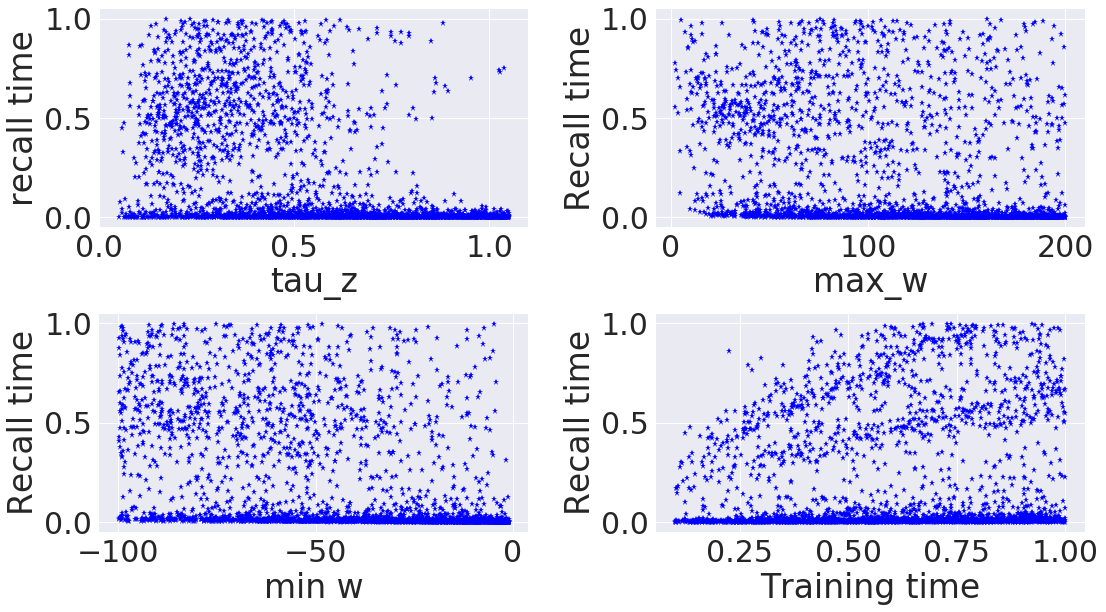

In [23]:
Y = y[small_domain_and_correct, :]
x = X[small_domain_and_correct, :]

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.tight_layout()

color = 'blue'

ax1.plot(x[:, 0], Y[:, 3], '*', color=color)
ax1.set_xlabel('tau_z')
ax1.set_ylabel('recall time')

ax2.plot(x[:, 1], Y[:, 3], '*', color=color)
ax2.set_xlabel('max_w')
ax2.set_ylabel('Recall time')

ax3.plot(x[:, 2], Y[:, 3], '*', color=color)
ax3.set_xlabel('min w')
ax3.set_ylabel('Recall time')


ax4.plot(x[:, 3], Y[:, 3], '*', color=color)
ax4.set_xlabel('Training time')
ax4.set_ylabel('Recall time');


## Recalling

In [24]:
x = X[small_domain_and_correct, :]
Y = y[small_domain_and_correct, :]
index = 1


N = 20
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

tau_z = 0.150


inter_sequence_time = 1.000
dt = 0.001
epochs = 4
tau_z_post = 0.005
tau_w = 0.100


G = 100.0
tau_m = 0.010
T = 10.0
I_cue = 0
I_end= 5

dt = 0.001

threshold = 0.5
tau_z = x[index, 0]
max_w = x[index, 1]
min_w = x[index, 2]
training_time = x[index, 3]
T_cue = tau_z

pattern = 3
pattern_from = 2
recall_times = []
dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=False,
                    pre_rule=False)
    
w = dic['w']
dic = run_network_recall_limit_end(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, I_end, T_cue)
x_history = dic['x']

duration = get_recall_duration_for_pattern(x_history, pattern, dt)
recall_times.append(duration)

self = w[pattern, pattern]
exc = w[pattern, pattern_from]
inh = w[pattern_from, pattern]

print('self', self, 'exc', exc, 'inh', inh)
print('self', Y[index, 0], 'exc', Y[index, 1], 'inh', Y[index, 2], 'recall time', Y[index, 3])
print('duration', duration)



self 45.027500543 exc 25.3792073245 inh -62.3181189758
self 45.027500543 exc 25.3792073245 inh -62.3181189758 recall time 0.565
duration 0.565


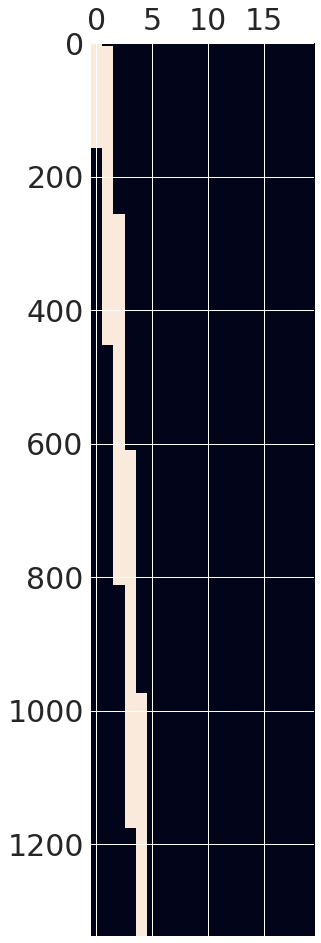

In [25]:
plt.matshow(x_history, aspect='auto')

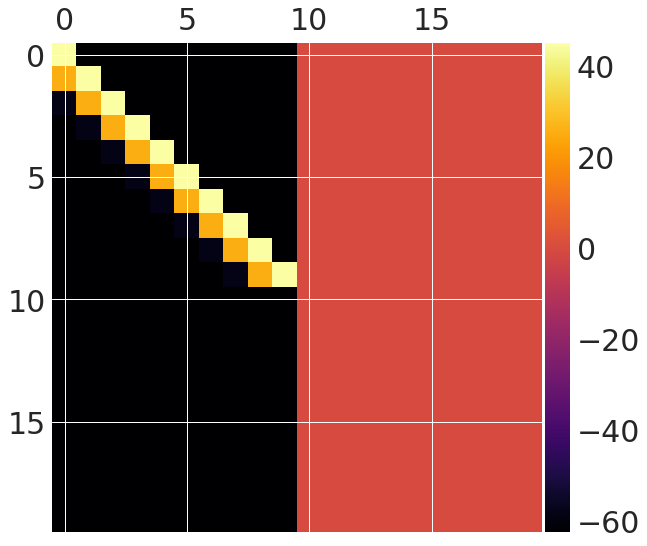

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

norm = matplotlib.colors.Normalize(0, 2)
cmap = matplotlib.cm.inferno

im = ax.matshow(w, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax);

Let's try to use the same patterns for overlap

In [30]:
x = X[small_domain_and_correct, :]
Y = y[small_domain_and_correct, :]
index = 50


N = 20
number_of_sequences = 2
half_width = 3
units_to_overload = [0, 1]
sequences = create_sequence_chain(number_of_sequences, half_width, units_to_overload)
print('sequences', sequences)

tau_z = 0.150


inter_sequence_time = 1.000
dt = 0.001
epochs = 4
tau_z_post = 0.005
tau_w = 0.100


G = 100.0
tau_m = 0.010
I_cue = 0
I_end= 5

dt = 0.001

threshold = 0.5
tau_z = x[index, 0]
max_w = x[index, 1]
min_w = x[index, 2]
training_time = x[index, 3]
T_cue = tau_z

pattern = 3
pattern_from = 2
recall_times = []
dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=False,
                    pre_rule=False)
    
w = dic['w']


self = w[pattern, pattern]
exc = w[pattern, pattern_from]
inh = w[pattern_from, pattern]

print('self', self, 'exc', exc, 'inh', inh)
print('self', Y[index, 0], 'exc', Y[index, 1], 'inh', Y[index, 2], 'recall time', Y[index, 3])


sequences [[2, 3, 4, 0, 1, 5, 6, 7], [8, 9, 10, 0, 1, 11, 12, 13]]
self 26.4804458452 exc 41.3441535508 inh -51.9934577293
self 26.4805727246 exc 41.3442476397 inh -51.9931956901 recall time 0.179


[8, 9, 10, 0, 1, 11, 12, 13]
success [ True]
ends [12]
should be 12


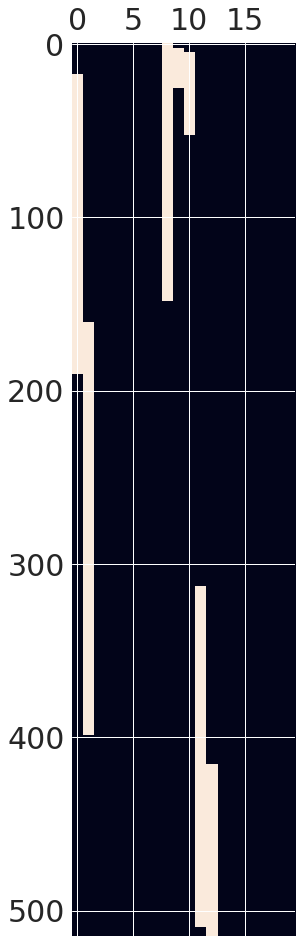

In [31]:
sequence = sequences[1]
print(sequence)
I_cue = sequence[0]
I_end = sequence[-1]
T = 10.0
dic = run_network_recall_limit_end(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, I_end, T_cue)
x_history = dic['x']
plt.matshow(x_history, aspect='auto')
last_pattern = x_history[-1]
# If the last element is zero
hits = last_pattern.sum()
if hits < 0.1 or hits > 1.5:
    success = 0.0
    ends = np.where(last_pattern > 0.5)[0]
    should_be = sequence[-2]
else:
    ends = np.where(last_pattern > 0.5)[0]
    should_be = sequence[-2]
    success = np.abs(ends - should_be) < 0.1
    
print('success', success)
print('ends', ends)
print('should be', should_be)

#### Systematic study of recall

In [40]:
x = X[small_domain_and_correct, :]
Y = y[small_domain_and_correct, :]
correct_build = np.zeros_like(Y)
n_sim = x.shape[0]
success_array = np.zeros((n_sim, 2))


N = 20
number_of_sequences = 2
half_width = 3
units_to_overload = [0, 1]
sequences = create_sequence_chain(number_of_sequences, half_width, units_to_overload)
pattern = 3
pattern_from = 2

inter_sequence_time = 1.000
dt = 0.001
epochs = 4
tau_z_post = 0.005
tau_w = 0.100
G = 100.0
tau_m = 0.010
dt = 0.001
threshold = 0.5

T = 10.0

n_frac = int(0.01 * n_sim)

for index in range(n_frac):
    print(index, n_frac)

    tau_z = x[index, 0]
    max_w = x[index, 1]
    min_w = x[index, 2]
    training_time = x[index, 3]
    T_cue = tau_z

    dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                        tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=False,
                        pre_rule=False)
    
    w = dic['w']
    
    self = w[pattern, pattern]
    exc = w[pattern, pattern_from]
    inh = w[pattern_from, pattern]
    
    print('self', self, 'exc', exc, 'inh', inh)
    print('self', Y[index, 0], 'exc', Y[index, 1], 'inh', Y[index, 2], 'recall time', Y[index, 3])

    
    correct_build[index, 0] = self - Y[index, 0]
    correct_build[index, 1] = exc - Y[index, 1]
    correct_build[index, 2] = inh - Y[index, 2]
    

    for i in range(len(sequences)):
        sequence = sequences[i]
        I_cue = sequence[0]
        I_end = sequence[-1]

        dic = run_network_recall_limit_end(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, I_end, T_cue)
        x_history = dic['x']

        last_pattern = x_history[-1]
        # If the last element is zero
        hits = last_pattern.sum()
        ends = np.where(last_pattern > 0.5)[0]
        should_be = sequence[-2]
        if hits < 0.1 or hits > 1.5:
            success = 0.0
        else:
            success = np.abs(ends - should_be) < 0.1
            
        print('success', success)
        print('ends', ends)
        print('should be', should_be)
        success_array[index, i] = success

0 28
self 0.288151742879 exc 70.7951659758 inh -47.7120996889
self 0.751102377303 exc 71.2893235612 inh -47.5137892894 recall time 0.005
success 0.0
ends []
should be 6
success 0.0
ends [ 1  8 11 12]
should be 12
1 28
self 45.027500543 exc 25.3792073245 inh -62.3181189758
self 45.027500543 exc 25.3792073245 inh -62.3181189758 recall time 0.565
success [False]
ends [13]
should be 6
success [ True]
ends [12]
should be 12
2 28
self 109.602363649 exc 149.328910015 inh -10.6797222142
self 109.602384161 exc 149.32891624 inh -10.6796896887 recall time 0.001
success 0.0
ends [ 0  1  2  3  4 11 12 13]
should be 6
success 0.0
ends [ 0  1  8  9 10 11 12]
should be 12
3 28
self 80.7150489608 exc 157.733156636 inh -67.2030481212
self 80.7156764292 exc 157.733369563 inh -67.2024123097 recall time 0.011
success 0.0
ends [12 13]
should be 6
success 0.0
ends [ 1  8 11 12]
should be 12
4 28
self 13.8005629496 exc 32.2582568636 inh -8.57520974415
self 13.8786186116 exc 32.333254946 inh -8.4933056033 reca

In [50]:
x = X[small_domain_and_correct, :]
Y = y[small_domain_and_correct, :]
correct_build = np.zeros_like(Y)
n_sim = x.shape[0]
success_array = np.zeros((n_sim, 2))


N = 20
number_of_sequences = 2
half_width = 3
units_to_overload = [0, 1]
sequences = create_sequence_chain(number_of_sequences, half_width, units_to_overload)
pattern = 3
pattern_from = 2

inter_sequence_time = 1.000
dt = 0.001
epochs = 4
tau_z_post = 0.005
tau_w = 0.100
G = 100.0
tau_m = 0.010
dt = 0.001
threshold = 0.5

T = 10.0

n_frac = int(1.0 * n_sim)

for index in range(n_frac):
    print(index, n_frac)

    tau_z = x[index, 0]
    max_w = x[index, 1]
    min_w = x[index, 2]
    training_time = x[index, 3]
    T_cue = tau_z

    dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                        tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=False,
                        pre_rule=False)
    
    w = dic['w']
    
    self = w[pattern, pattern]
    exc = w[pattern, pattern_from]
    inh = w[pattern_from, pattern]
    
    correct_build[index, 0] = np.abs(self - Y[index, 0])
    correct_build[index, 1] = np.abs(exc - Y[index, 1])
    correct_build[index, 2] = np.abs(inh - Y[index, 2])
    

    for i in range(len(sequences)):
        sequence = sequences[i]
        I_cue = sequence[0]
        I_end = sequence[-1]

        dic = run_network_recall_limit_end(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, I_end, T_cue)
        x_history = dic['x']

        last_pattern = x_history[-1]
        # If the last element is zero
        hits = last_pattern.sum()
     
        if hits < 0.1 or hits > 1.5:
            success = 0.0
        else:
            ends = np.where(last_pattern > 0.5)[0]
            should_be = sequence[-2]
            success = np.abs(ends - should_be) < 0.1

        success_array[index, i] = success

0 2892
1 2892
2 2892
3 2892
4 2892
5 2892
6 2892
7 2892
8 2892
9 2892
10 2892
11 2892
12 2892
13 2892
14 2892
15 2892
16 2892
17 2892
18 2892
19 2892
20 2892
21 2892
22 2892
23 2892
24 2892
25 2892
26 2892
27 2892
28 2892
29 2892
30 2892
31 2892
32 2892
33 2892
34 2892
35 2892
36 2892
37 2892
38 2892
39 2892
40 2892
41 2892
42 2892
43 2892
44 2892
45 2892
46 2892
47 2892
48 2892
49 2892
50 2892
51 2892
52 2892
53 2892
54 2892
55 2892
56 2892
57 2892
58 2892
59 2892
60 2892
61 2892
62 2892
63 2892
64 2892
65 2892
66 2892
67 2892
68 2892
69 2892
70 2892
71 2892
72 2892
73 2892
74 2892
75 2892
76 2892
77 2892
78 2892
79 2892
80 2892
81 2892
82 2892
83 2892
84 2892
85 2892
86 2892
87 2892
88 2892
89 2892
90 2892
91 2892
92 2892
93 2892
94 2892
95 2892
96 2892
97 2892
98 2892
99 2892
100 2892
101 2892
102 2892
103 2892
104 2892
105 2892
106 2892
107 2892
108 2892
109 2892
110 2892
111 2892
112 2892
113 2892
114 2892
115 2892
116 2892
117 2892
118 2892
119 2892
120 2892
121 2892
122 2892
123

923 2892
924 2892
925 2892
926 2892
927 2892
928 2892
929 2892
930 2892
931 2892
932 2892
933 2892
934 2892
935 2892
936 2892
937 2892
938 2892
939 2892
940 2892
941 2892
942 2892
943 2892
944 2892
945 2892
946 2892
947 2892
948 2892
949 2892
950 2892
951 2892
952 2892
953 2892
954 2892
955 2892
956 2892
957 2892
958 2892
959 2892
960 2892
961 2892
962 2892
963 2892
964 2892
965 2892
966 2892
967 2892
968 2892
969 2892
970 2892
971 2892
972 2892
973 2892
974 2892
975 2892
976 2892
977 2892
978 2892
979 2892
980 2892
981 2892
982 2892
983 2892
984 2892
985 2892
986 2892
987 2892
988 2892
989 2892
990 2892
991 2892
992 2892
993 2892
994 2892
995 2892
996 2892
997 2892
998 2892
999 2892
1000 2892
1001 2892
1002 2892
1003 2892
1004 2892
1005 2892
1006 2892
1007 2892
1008 2892
1009 2892
1010 2892
1011 2892
1012 2892
1013 2892
1014 2892
1015 2892
1016 2892
1017 2892
1018 2892
1019 2892
1020 2892
1021 2892
1022 2892
1023 2892
1024 2892
1025 2892
1026 2892
1027 2892
1028 2892
1029 2892
1030 28

1750 2892
1751 2892
1752 2892
1753 2892
1754 2892
1755 2892
1756 2892
1757 2892
1758 2892
1759 2892
1760 2892
1761 2892
1762 2892
1763 2892
1764 2892
1765 2892
1766 2892
1767 2892
1768 2892
1769 2892
1770 2892
1771 2892
1772 2892
1773 2892
1774 2892
1775 2892
1776 2892
1777 2892
1778 2892
1779 2892
1780 2892
1781 2892
1782 2892
1783 2892
1784 2892
1785 2892
1786 2892
1787 2892
1788 2892
1789 2892
1790 2892
1791 2892
1792 2892
1793 2892
1794 2892
1795 2892
1796 2892
1797 2892
1798 2892
1799 2892
1800 2892
1801 2892
1802 2892
1803 2892
1804 2892
1805 2892
1806 2892
1807 2892
1808 2892
1809 2892
1810 2892
1811 2892
1812 2892
1813 2892
1814 2892
1815 2892
1816 2892
1817 2892
1818 2892
1819 2892
1820 2892
1821 2892
1822 2892
1823 2892
1824 2892
1825 2892
1826 2892
1827 2892
1828 2892
1829 2892
1830 2892
1831 2892
1832 2892
1833 2892
1834 2892
1835 2892
1836 2892
1837 2892
1838 2892
1839 2892
1840 2892
1841 2892
1842 2892
1843 2892
1844 2892
1845 2892
1846 2892
1847 2892
1848 2892
1849 2892


2570 2892
2571 2892
2572 2892
2573 2892
2574 2892
2575 2892
2576 2892
2577 2892
2578 2892
2579 2892
2580 2892
2581 2892
2582 2892
2583 2892
2584 2892
2585 2892
2586 2892
2587 2892
2588 2892
2589 2892
2590 2892
2591 2892
2592 2892
2593 2892
2594 2892
2595 2892
2596 2892
2597 2892
2598 2892
2599 2892
2600 2892
2601 2892
2602 2892
2603 2892
2604 2892
2605 2892
2606 2892
2607 2892
2608 2892
2609 2892
2610 2892
2611 2892
2612 2892
2613 2892
2614 2892
2615 2892
2616 2892
2617 2892
2618 2892
2619 2892
2620 2892
2621 2892
2622 2892
2623 2892
2624 2892
2625 2892
2626 2892
2627 2892
2628 2892
2629 2892
2630 2892
2631 2892
2632 2892
2633 2892
2634 2892
2635 2892
2636 2892
2637 2892
2638 2892
2639 2892
2640 2892
2641 2892
2642 2892
2643 2892
2644 2892
2645 2892
2646 2892
2647 2892
2648 2892
2649 2892
2650 2892
2651 2892
2652 2892
2653 2892
2654 2892
2655 2892
2656 2892
2657 2892
2658 2892
2659 2892
2660 2892
2661 2892
2662 2892
2663 2892
2664 2892
2665 2892
2666 2892
2667 2892
2668 2892
2669 2892


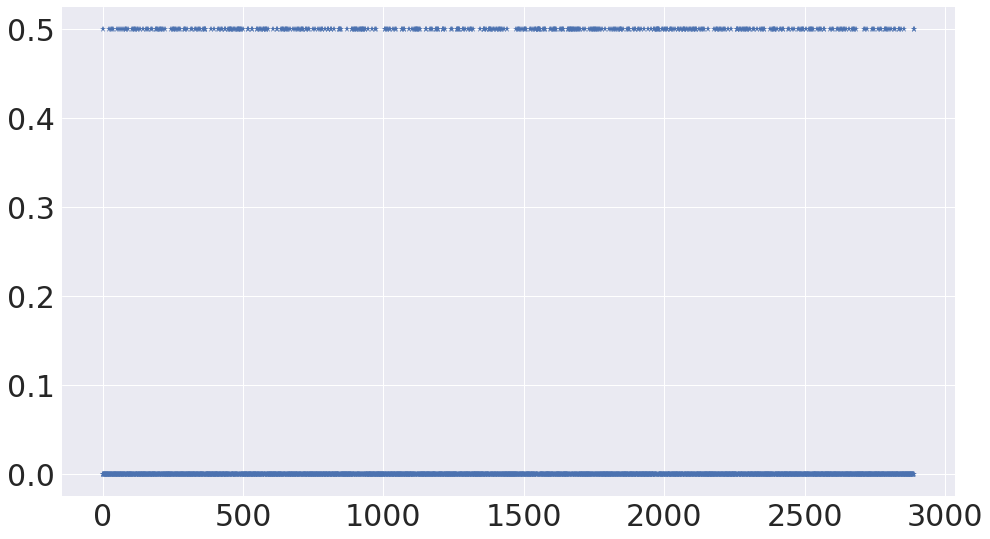

In [52]:
plt.plot(success_array[:n_frac, :].mean(axis=1), '*')

In [57]:
x = success_array

In [58]:
np.where(x == 1)

(array([   1,   23,   29,   35,   38,   50,   59,   67,   72,   79,   83,
          84,   91,  106,  108,  110,  115,  116,  122,  125,  132,  144,
         154,  157,  160,  173,  176,  189,  191,  195,  198,  203,  204,
         208,  213,  215,  222,  244,  249,  250,  254,  259,  263,  270,
         272,  275,  291,  292,  294,  299,  316,  319,  329,  331,  339,
         343,  347,  356,  360,  364,  365,  366,  386,  397,  411,  413,
         423,  424,  436,  437,  448,  450,  454,  455,  457,  458,  465,
         468,  472,  479,  482,  483,  484,  485,  489,  491,  493,  500,
         518,  519,  531,  533,  548,  551,  556,  561,  565,  571,  573,
         575,  581,  582,  583,  590,  605,  620,  622,  636,  638,  642,
         643,  650,  652,  653,  657,  659,  668,  679,  685,  692,  697,
         701,  706,  710,  711,  713,  724,  725,  730,  735,  750,  758,
         767,  774,  781,  782,  792,  801,  803,  814,  815,  824,  841,
         842,  845,  846,  850,  870, 

Always the second one wins

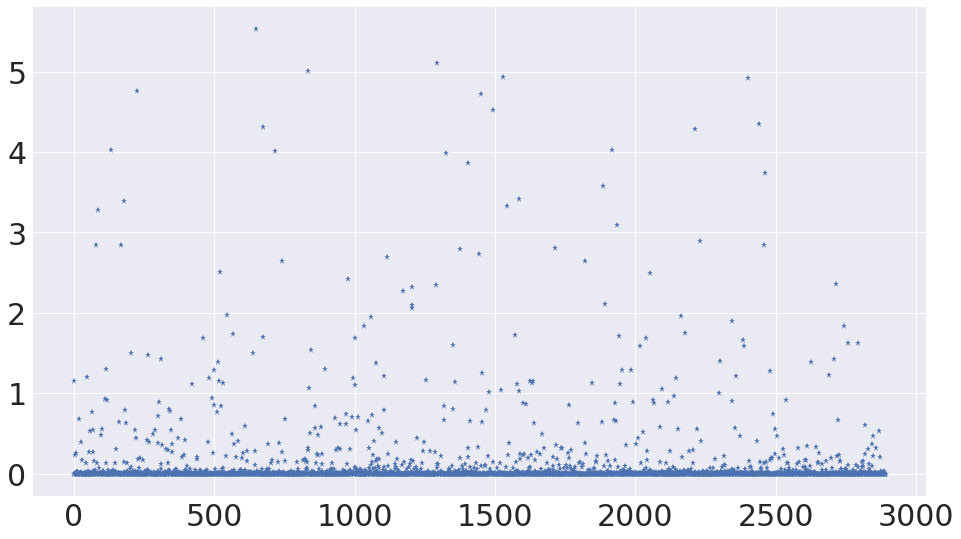

In [59]:
plt.plot(correct_build.sum(axis=1), '*')

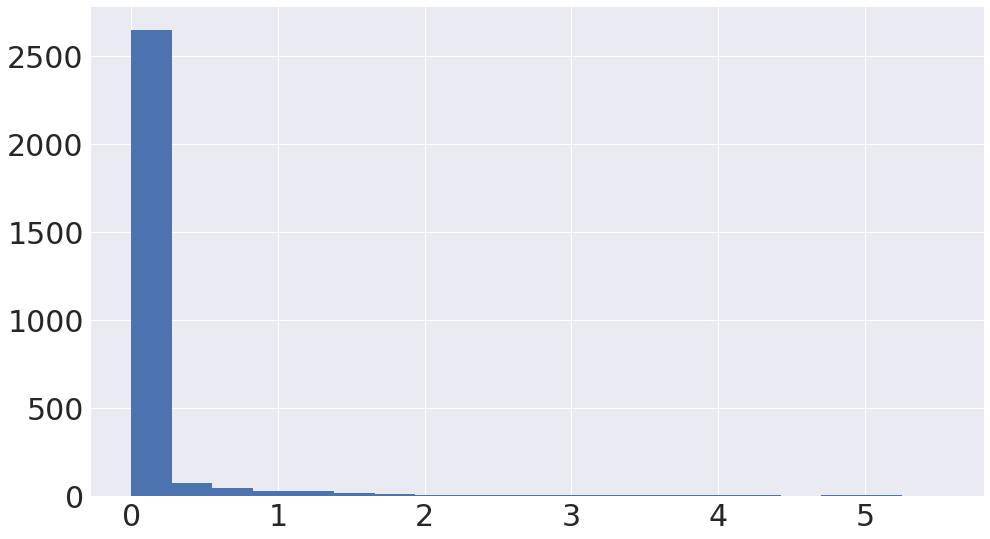

In [63]:
plt.hist(correct_build.sum(axis=1), bins=20);

Most of them are correctly bin

In [ ]:
x = X[small_domain_and_correct, :]
Y = y[small_domain_and_correct, :]